<a href="https://colab.research.google.com/github/eser1303/Vizualization_3/blob/main/LabPlace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Домашнее задание №3 по курсу "Методы визуализации данных"

###Выполнил Ефремов Сергей Владимирович, группа М05-013г

###Label placement

Задача выполнена без ограничений на количество вариантов, при использовании стороннего SAT-решателя.

Используется бинарная кодировка каждой потенциальной позиции для каждого бокса.

Давайте договоримся сделать в едином формате, на каждый label по строке следующего вида:



```
позиция <таб> размер <таб> варианты_расположений_через_пробел
```

Пример для 2 label'ов:



```
25,20  10,10  0,0 10,0 0,10 10,10

25,40  10,30  0,0 10,0 0,15 10,15 0,30 10,30
```
Выражаю огромную благодарность Дьяченко Игорю за предоставленные примеры и набросок парсера.

Используемый SAT парсер: 

https://pysathq.github.io/

In [178]:
!pip install python-sat

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

MAX_LIMIT = 500
raw_data = '''
25,20	10,10	0,0 10,0 0,10 10,10
25,40	10,30	0,0 10,0 0,15 10,15 0,30 10,30
25,60	10,10	0,0 10,0 0,10 10,10
40,25	20,10	0,0 10,0 20,0 0,10 10,10 20,10
40,40	20,20	0,0 10,0 20,0 0,10 10,10 20,10 0,20 10,20 20,20
40,55	20,10	0,0 10,0 20,0 0,10 10,10 20,10
55,35	10,20	0,0 10,0 0,10 10,10 0,20 10,20
55,40	10,20	0,0 10,0 0,10 10,10 0,20 10,20
'''    
def parse(s):
   arr = [int(a) for a in s.split(',')]
   return np.array(arr)

class Box:
    def __init__(self, line):
        arr = line.split('\t')
        self.pos = parse(arr[0])
        self.size = parse(arr[1])
        self.offsets = [parse(pos) for pos in arr[2].split(' ')]
        assert len(self.offsets) > 0
    
    def __str__(self):
        return 'Box(pos={}, size={}, offsets={})'.format(self.pos, self.size, self.offsets)
    
    def __repr__(self):
        return str(self)


boxes = [Box(line) for line in raw_data.strip().split('\n')]

In [180]:
def check_sec(boxes, i, j, it1, it2):
   pos1 = boxes[i].pos - boxes[i].offsets[it1]
   pos2 = boxes[j].pos - boxes[j].offsets[it2]
   sz1 = boxes[i].size
   sz2 = boxes[j].size
   if ((pos1[0] + sz1[0]) < pos2[0]) or ((pos2[0] + sz2[0]) < pos1[0]) or ((pos1[1] + sz1[1]) < pos2[1]) or ((pos2[1] + sz2[1]) < pos1[1]):
     return 0
   else:
     return 1

In [181]:
s = CNF()
toq = {}
fromq = {}
key = 1
for i in range(len(boxes)):
  L = len(boxes[i].offsets)
  k = range (key, L + key, 1)
  s.append(k)
  for j in k:
    toq[j] = [i, j - key]
    fromq[(i, j - key)] = j
  key += L
for i in range(len(boxes)):
  for j in range(i + 1, len(boxes)):
    k1 = range(len(boxes[i].offsets))
    k2 = range(len(boxes[j].offsets))
    for it1 in k1:
      for it2 in k2:
        flag = check_sec(boxes, i, j, it1, it2)
        if flag == 1:
          q1 = fromq[(i, it1)]
          q2 = fromq[(j, it2)]
          s.append([-q1, -q2])

In [182]:
error_flag = 0
with Minisat22(bootstrap_with = s) as m:
   m.solve()
   pre_res = m.get_model()
   if pre_res:
     res = np.array(m.get_model())
   else:
     error_flag = 1
if error_flag == 0:
  res_q = {}
  for i in res:
    if i > 0:
      q = toq[i]
      res_q[q[0]] = boxes[q[0]].offsets[q[1]]

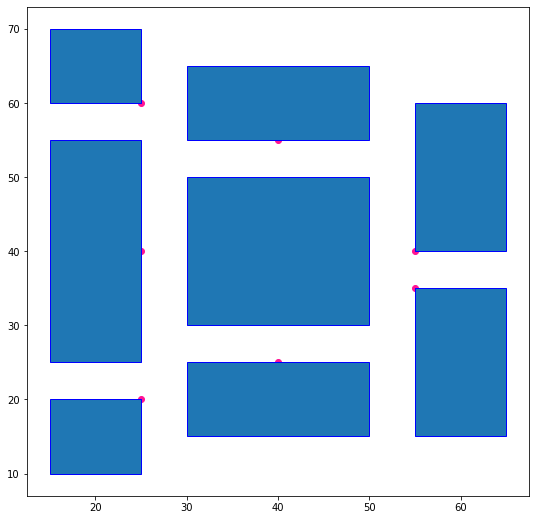

In [184]:
if error_flag == 0:
  fig, ax = plt.subplots(figsize=(9,9))
  for i in range(len(boxes)):
    if max(boxes[i].pos - res_q[i]) <= 500:
      ax.scatter(boxes[i].pos[0], boxes[i].pos[1], c = 'deeppink')
      ax.add_patch(
           patches.Rectangle(
              boxes[i].pos - res_q[i],
              boxes[i].size[0],
              boxes[i].size[1],
              edgecolor = 'blue',
              #facecolor = 'blue',
              fill=True
           ) )
    else:
      error_flag = 1
if error_flag == 0:
  plt.show()
else:
  print('Imposible to draw')